<a href="https://colab.research.google.com/github/marinavillaschi/portfolio_datascience_mpv/blob/main/Previs%C3%A3o_de_churn_para_empresa_de_telecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de ***churn*** para empresa de telecomunicações


*by [Marina Villaschi](https://www.linkedin.com/in/marinavillaschi)*

<center><img width="90%" src="http://images.unsplash.com/photo-1520033906782-1684d0e7498e?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=1080&fit=max"></center>


<center>Photo by <a href="https://unsplash.com/@jasmund?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Michael Jasmund</a> on <a href="https://unsplash.com/?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a><center>



Partindo do princípio que o objetivo de qualquer negócio é aumentar o número de clientes, é muito importante entender que para que isto aconteça, não basta apenas atrair novos clientes, é necessário manter os que já estão ali.

Manter os clientes pode ser mais fácil que atrair novos, já que estes podem estar menos interessados nos serviços oferecidos e não possuem um relacionamento prévio com a empresa.
Além do mais, **manter um cliente custa menos para a empresa que atrair novos**. 

Ao prever a rotatividade de clientes existentes, ou seja, ao realizar o *churn prediction*, é possível antecipar quando um cliente pretende cancelar um serviço e com isso, reagir a tempo para mantê-lo (criando ofertas especiais, por exemplo). Isso só é possível pois já temos dados desses cliente para analisarmos, ao contrário de novos clientes que queremos atrair que não sabemos nada sobre ele.

O desafio é **prever** e tomar medidas para **reduzir ao máximo o *churn***, garantindo assim clientes satisfeitos e que não pretendem deixar de assinar o produto.



## Obtenção dos Dados

Os dados utilizados nesse projeto foram obtidos do [Telecom Users Dataset](https://www.kaggle.com/radmirzosimov/telecom-users-dataset) disponível do Kaggle, que contém dados de uma **empresa de telecomunicações**.

O dataset possui informações de quase **6 mil usuários**, suas características demográficas, serviços utilizados, duração de utilização dos serviços, valor e forma de pagamento.



In [ ]:
# ignorar warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalando pandas profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

# importando bibliotecas e pacotes necessários
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# random seed
np.random.seed(42)

# importando o arquivo para um DataFrame
df = pd.read_csv("https://raw.githubusercontent.com/marinavillaschi/datafiles/main/telecom_users.csv")

## Análise Exploratória dos Dados

Vamos começar a conhecer nosso dataset através da Análise Exploratória dos Dados, passo extremamente importante do projeto.



### Variáveis e entradas

Vamos explorar as variáveis e entradas para já mapear os próximos passos a serem realizados na etapa de preparação dos dados. Para isso, vamos verificar:

* o tamanho do dataframe, ou seja, quantas variáveis e quantas entradas possui

In [ ]:
# imprimindo a quantidade de variáveis e entradas do dataframe
print("Entradas:  ", df.shape[0], "\nVariáveis: ", df.shape[1])

Entradas:   5986 
Variáveis:  22


* as primeiras entradas do dataframe

In [ ]:
# imprimindo as 5 primeiras entradas do dataframe
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


* os nomes e tipos das variáveis (colunas)

In [ ]:
# imprimindo os nomes e tipos das variáveis
print("Tipos de Variáveis:\n")
print(df.dtypes)

Tipos de Variáveis:

Unnamed: 0            int64
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


* Valores únicos das colunas

In [ ]:
print("Valores únicos:\n")
print(df.nunique())

Valores únicos:

Unnamed: 0          5986
customerID          5986
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1526
TotalCharges        5611
Churn                  2
dtype: int64


Temos muitas variáveis do tipo `object` representando variáveis categóricas binárias e múltiplas que precisarão ser transformadas em numéricas discretas.

É possível observar também que a variável `TotalCharges` deveria ser do tipo `float` e está no formato `object`, então precisaremos transformá-la.

* a lista das variáveis e suas descrições

  * `customerID`: ID do usuário

  * `gender`: gênero do cliente (male / female)

  * `SeniorCitizen`: se o cliente é aposentado (1, 0)

  * `Partner`: se o cliente é casado (Yes, No)

  * `tenure`: há quantos meses é cliente da empresa

  * `PhoneService`: se o serviço de telefonia está conectado (Yes, No)

  * `MultipleLines`: se tem multiplas linhas telefônicas conectadas (Yes, No, No phone service)

  * `InternetService`: provedor de serviço de internet do cliente (DSL, Fiber optic, No)

  * `OnlineSecurity`: se o serviço de segurança online está conectado (Yes, No, No internet service)

  * `OnlineBackup`: se o serviço de backup online está ativo (Yes, No, No internet service)

  * `DeviceProtection`: se o cliente possui seguro do equipamento (Yes, No, No internet service)

  * `TechSupport`: se o suporte técnico está conectado (Yes, No, No internet service)

  * `StreamingTV`: se o serviço de streaming para TV está conectado (Yes, No, No internet service)

  * `StreamingMovies`: se o serviço de streaming de filmes está ativo (Yes, No, No internet service)

  * `Contract`: tipo de contrato (Month-to-month, One year, Two year)

  * `PaperlessBilling`: se o cliente recebe a conta por meios digitais, sem uso de papel (Yes, No)

  * `PaymentMethod`: forma de pagamento (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

  * `MonthlyCharges`: valor do pagamento mensal atual

  * `TotalCharges`: valor total pago pelo cliente pelos serviços durante todo o tempo

  * `Churn`: se houve cancelamento, ou seja, se houve *churn* (Yes, No)

Por fim, vale ressaltar que a nossa variável alvo é a `Churn`.

### Valores ausentes

A proporção de valores ausentes do dataset tem relação direta com a qualidade do mesmo.

Vamos imprimir a proporção de valores ausentes em cada coluna:

In [ ]:
# imprimindo a proporção dos dados ausentes em cada coluna
(df.isnull().sum()/df.shape[0]).sort_values()

Unnamed: 0          0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Contract            0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
InternetService     0.0
MultipleLines       0.0
PhoneService        0.0
tenure              0.0
Dependents          0.0
Partner             0.0
SeniorCitizen       0.0
gender              0.0
customerID          0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

Conforme visto, o dataset não possui nenhuma coluna com valores ausentes. Isso indica ótima qualidade do dataset, porém também indica que devemos ficar atentos pois essa pode não ser a realidade.

Iremos investigar isso através da variável `TotalCharges` que identificamos como `object` e deve ser tipo `float`. Pode ser que ela tenha valores nulos e que não seja possível identificar sem antes transformá-la.



In [ ]:
#criando uma cópia do df
df_clean = df.copy()

# transformando a variável TotalCharges em float
df_clean.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

# verificando o tipo da variável TotalCharges após transformação
print("Tipo da variável TotalCharges:\t{}\n".format(df_clean.TotalCharges.dtypes))

# verificando valores nulos após transformação
print("Total de dados ausentes em TotalCharges após transformação para float:\t{}\n".format(df_clean.TotalCharges.isnull().sum()))

Tipo da variável TotalCharges:	float64

Total de dados ausentes em TotalCharges após transformação para float:	10



Após a transformação da variável `TotalCharges` vimos que a mesma possui alguns valores ausentes.

Vamos substituir esses valores ausentes pela mediana da coluna.

In [ ]:
# extraindo a mediana da coluna
TC_median = df_clean.TotalCharges.median()

# substituindo os valores nulos pela mediana da coluna
df_clean.TotalCharges.fillna(TC_median, inplace=True)

# verificando se o total de valores nulos zerou
print("Total de dados ausentes em TotalCharges (final):\t{}\n".format(df_clean.TotalCharges.isnull().sum()))


Total de dados ausentes em TotalCharges (final):	0



Pronto, agora identificamos e tratamos o tipo de variável e seus dados ausentes.

### Resumo estatístico

Vamos imprimir o resumo estatístico das variáveis numéricas:

In [ ]:
df_clean.describe()

,Unnamed: 0,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000
mean,3533.561310,0.161377,32.468760,64.802213,2296.580647
std,2035.705666,0.367909,24.516391,30.114702,2272.514574
min,0.000000,0.000000,0.000000,18.250000,18.800000
25%,1777.250000,0.000000,9.000000,35.650000,406.275000
50%,3546.500000,0.000000,29.000000,70.400000,1412.150000
75%,5291.750000,0.000000,56.000000,89.900000,3841.500000
max,7042.000000,1.000000,72.000000,118.750000,8684.800000


A variável `SeniorCitizen`é composta de 1 e 0 para aposentado e não aposentado respectivamente. É possivel perceber que a grande maioria dos clientes não são aposentados.

A variável `tenure` (tempo que a pessoa é cliente da empresa) nos mostra valor máximo de 6 anos (72 meses), 75% dos clientes com tempo acima de 4 anos e meio (56 meses) e uma média de 2 anos e 8 meses (32 meses). Esses valores parecem coerentes e também podem demonstrar satisfação dos clientes a longo prazo.

As variáveis `MonthlyCharges` e `TotalCharges` apresentam valores coerentes e bons, já que a maioria dos clientes (75%) efetua pagamento mensal e total superior à média.

A princípio, não foram identificados *outliers*, vamos confirmar isto plotando os boxplots.

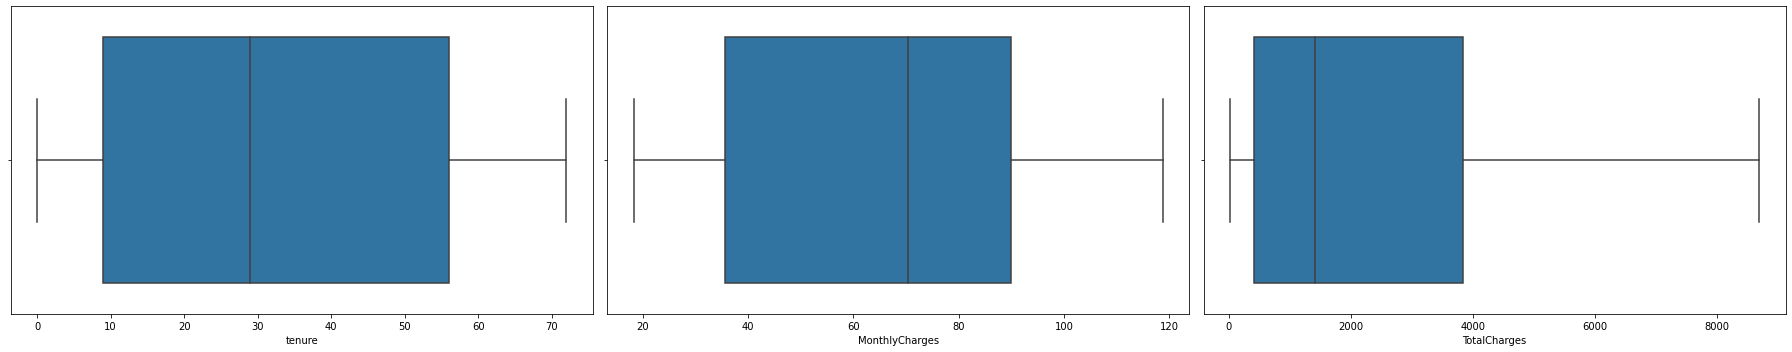

In [ ]:
# plotando os boxplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(25,5))
sns.boxplot(df_clean.tenure, ax=ax1)
sns.boxplot(df_clean.MonthlyCharges, ax=ax2)
sns.boxplot(df_clean.TotalCharges, ax=ax3)
plt.tight_layout()

Pelos boxplots acima é possível confirmar que não há *outliers*, já que nenhuma das variáveis apresenta valores fora dos limites superior e inferior.

### Distribuição da variável alvo


Temos como variável alvo, ou seja, aquela que queremos prever, a `Churn`.

Para entender como está a distribuição dela no dataset, vamos plotar um gráfico de barras para visualizar o balanceamento dessa variável.

No     4399
Yes    1587
Name: Churn, dtype: int64


Churn = 36.08 %




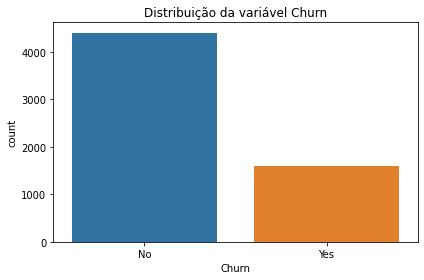

In [ ]:
# ver balanceamento da variável Churn
print(df.Churn.value_counts())
print('\n')
print('Churn =', round(((df.loc[df.Churn == 'Yes'].shape[0])/(df.loc[df.Churn == 'No'].shape[0])*100),2),'%')
print('\n')

# imprimir countplot
fig, ax = plt.subplots()
sns.countplot(x=df.Churn, ax=ax)
ax.set_title('Distribuição da variável Churn')
plt.tight_layout()

É possível perceber **desbalanceamento leve** da variável alvo.

A princípio, vamos manter os dados com a distribuição real. Com isto poderemos avaliar o quanto esse desbalanceamento afetará o desempenho do modelo de Machine Learning. Após treinar o modelo avaliaremos se será melhor balanceá-los.

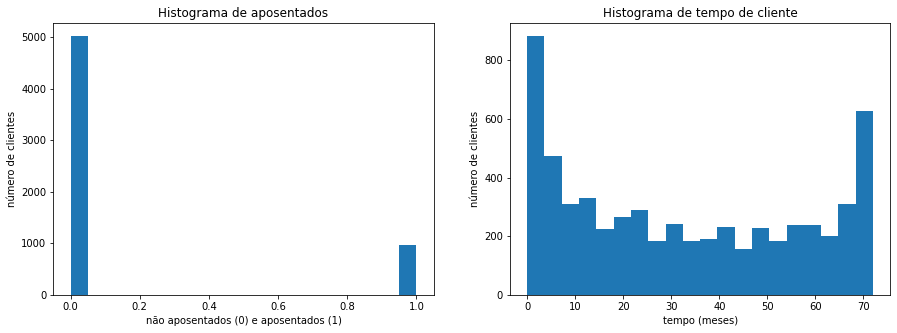

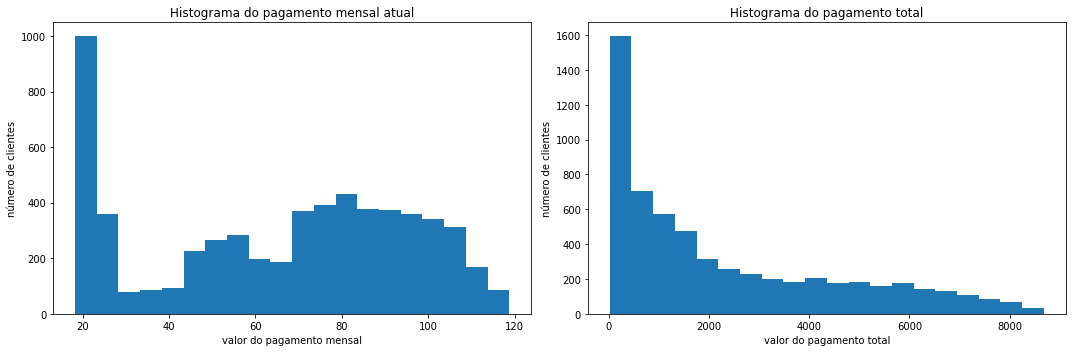

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.hist(df_clean.SeniorCitizen, bins=20)
ax1.set_title("Histograma de aposentados")
ax1.set_ylabel("número de clientes")
ax1.set_xlabel("não aposentados (0) e aposentados (1)")

ax2.hist(df_clean.tenure, bins=20)
ax2.set_title("Histograma de tempo de cliente")
ax2.set_ylabel("número de clientes")
ax2.set_xlabel("tempo (meses)")

fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax3.hist(df_clean.MonthlyCharges, bins=20)
ax3.set_title("Histograma do pagamento mensal atual")
ax3.set_ylabel("número de clientes")
ax3.set_xlabel("valor do pagamento mensal")

ax4.hist(df_clean.TotalCharges, bins=20)
ax4.set_title("Histograma do pagamento total")
ax4.set_ylabel("número de clientes")
ax4.set_xlabel("valor do pagamento total")

plt.tight_layout()

Pelos histogramas plotados acima, observamos que:
* a maior parte dos clientes não são aposentados, confirmando o que observamos no resumo estatístico;
* existe um grande número de clientes novos (mais de 800 clientes com menos de 5 meses) e outro grande número de clientes bem antigos (cerca de 600 clientes com aproximadamente 70 meses -mais de 5 anos e meio-);
* muitos clientes efetuam pagamento mensal baixo, de aproximadamente 20 (moeda local);
* muitos clientes tem baixo valor total pago (abaixo de 2000), e poucos clientes tem alto valor total pago.

### Correlação entre variáveis

Por último, vamos explorar a relação entre as variáveis numéricas. 

Através do coeficiente de correlação iremos criar uma matriz de correlação e gerar um *heatmap* para visualizarmos.

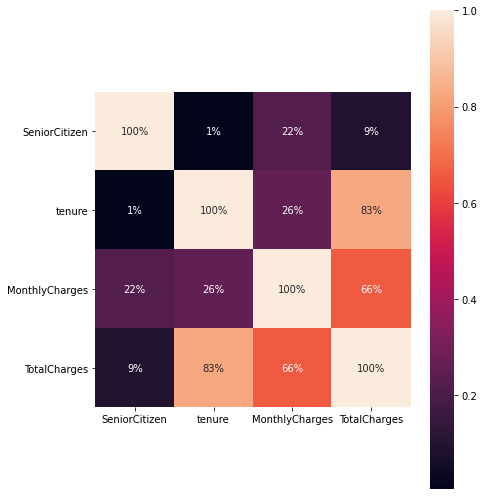

In [ ]:
# criando matriz de correlação
corr = df_clean[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']].corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr, fmt='.0%', annot=True, square=True)
plt.tight_layout()

É possível estabelecer algumas correlações entre as variáveis, porem a maioria das variáveis ainda não estão em formato numérico, o que nos impede de visualizar a correlação verdadeira em forma de matriz.

Iremos transformar essas variáveis categóricas em numéricas na fase seguinte (preparação dos dados) para então obtermos novamente a matriz de correlação e sermos capazes de avaliá-la.

## Preparação dos dados

A partir da Análise Exploratória feita acima, vamos resumir o que identificamos a ser feito nessa etapa de preparação dos dados para que possam ser utilizados para construir o modelo de Machine Learning:

* **Transformar** variáveis categóricas em numéricas discretas;

* **Padronizar** as variáveis `tenure`, `MonthlyCharges` e `TotalCharges`;

* **Selecionar** as variáveis que são interessantes e eliminar as que não serão úteis ou são menos relevantes ao modelo;

**Inicialmente** iremos construir e treinar o modelo com os **dados desbalanceados**, iremos avaliar a performance do modelo para termos uma base comparativa e se necessário, vamos balancear os dados e então treinar o modelo novamente.


### Transformação das variáveis categóricas

Faremos a transformação das variáveis categóricas de duas formas: utilizando `get_dummies` para as variáveis categóricas múltiplas e utilizando o `LabelEncoder` para as demais variáveis.

In [ ]:
# criando uma cópia de df para realizarmos as preparações
df_prep = df_clean.copy()

# codificando as variáveis categóricas múltiplas com get_dummies
df_prep = pd.get_dummies(df_prep, columns=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'], drop_first=True)
df_prep.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,No,24.10,1734.65,No,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,Yes,88.15,3973.20,No,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,74.95,2869.85,Yes,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6739,6994-KERXL,Male,0,No,No,4,Yes,Yes,55.90,238.50,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,53.45,119.50,No,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# codificando as demais variáveis com LabelEncoder
categorical_feature_mask = df_prep.dtypes==object
categorical_cols = df_prep.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
df_prep[categorical_cols] = df_prep[categorical_cols].apply(lambda col: le.fit_transform(col))
df_prep.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1869,4252,1,0,1,1,72,1,0,24.10,1734.65,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0
1,4528,5806,0,0,0,0,44,1,1,88.15,3973.20,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
2,6344,5577,0,1,1,0,38,1,1,74.95,2869.85,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6739,4243,1,0,0,0,4,1,1,55.90,238.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,432,1270,1,0,0,0,2,1,0,53.45,119.50,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


### Padronização das variáveis

Conforme observamos na análise exploratória, além das variáveis categóricas que acabamos de transformar em numéricas discretas, temos duas variáveis numéricas que precisam ser padronizadas.

Faremos isso com o `StandardScaler` para as variáveis `tenure`, `MonthlyCharges` e `TotalCharges`.

In [ ]:
# padronizando as colunas tenure, MonthlyCharges e TotalCharges
scaler = StandardScaler()
df_prep['scaled_tenure'] = scaler.fit_transform(df_prep.tenure.values.reshape(-1,1))
df_prep['scaled_MonthlyCharges'] = scaler.fit_transform(df_prep.MonthlyCharges.values.reshape(-1,1))
df_prep['scaled_TotalCharges'] = scaler.fit_transform(df_prep.TotalCharges.values.reshape(-1,1))

df_prep.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1, inplace=True)

df_prep.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,scaled_tenure,scaled_MonthlyCharges,scaled_TotalCharges
0,1869,4252,1,0,1,1,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1.612576,-1.351686,-0.247293
1,4528,5806,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0.470387,0.775360,0.737843
2,6344,5577,0,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.225633,0.336999,0.252283
3,6739,4243,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,-1.161310,-0.295635,-0.905716
4,432,1270,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,-1.242895,-0.376997,-0.958085


Vamos agora plotar novamente um *heatmap* da matriz de correlação das variáveis, pois agora conseguiremos avaliá-la.

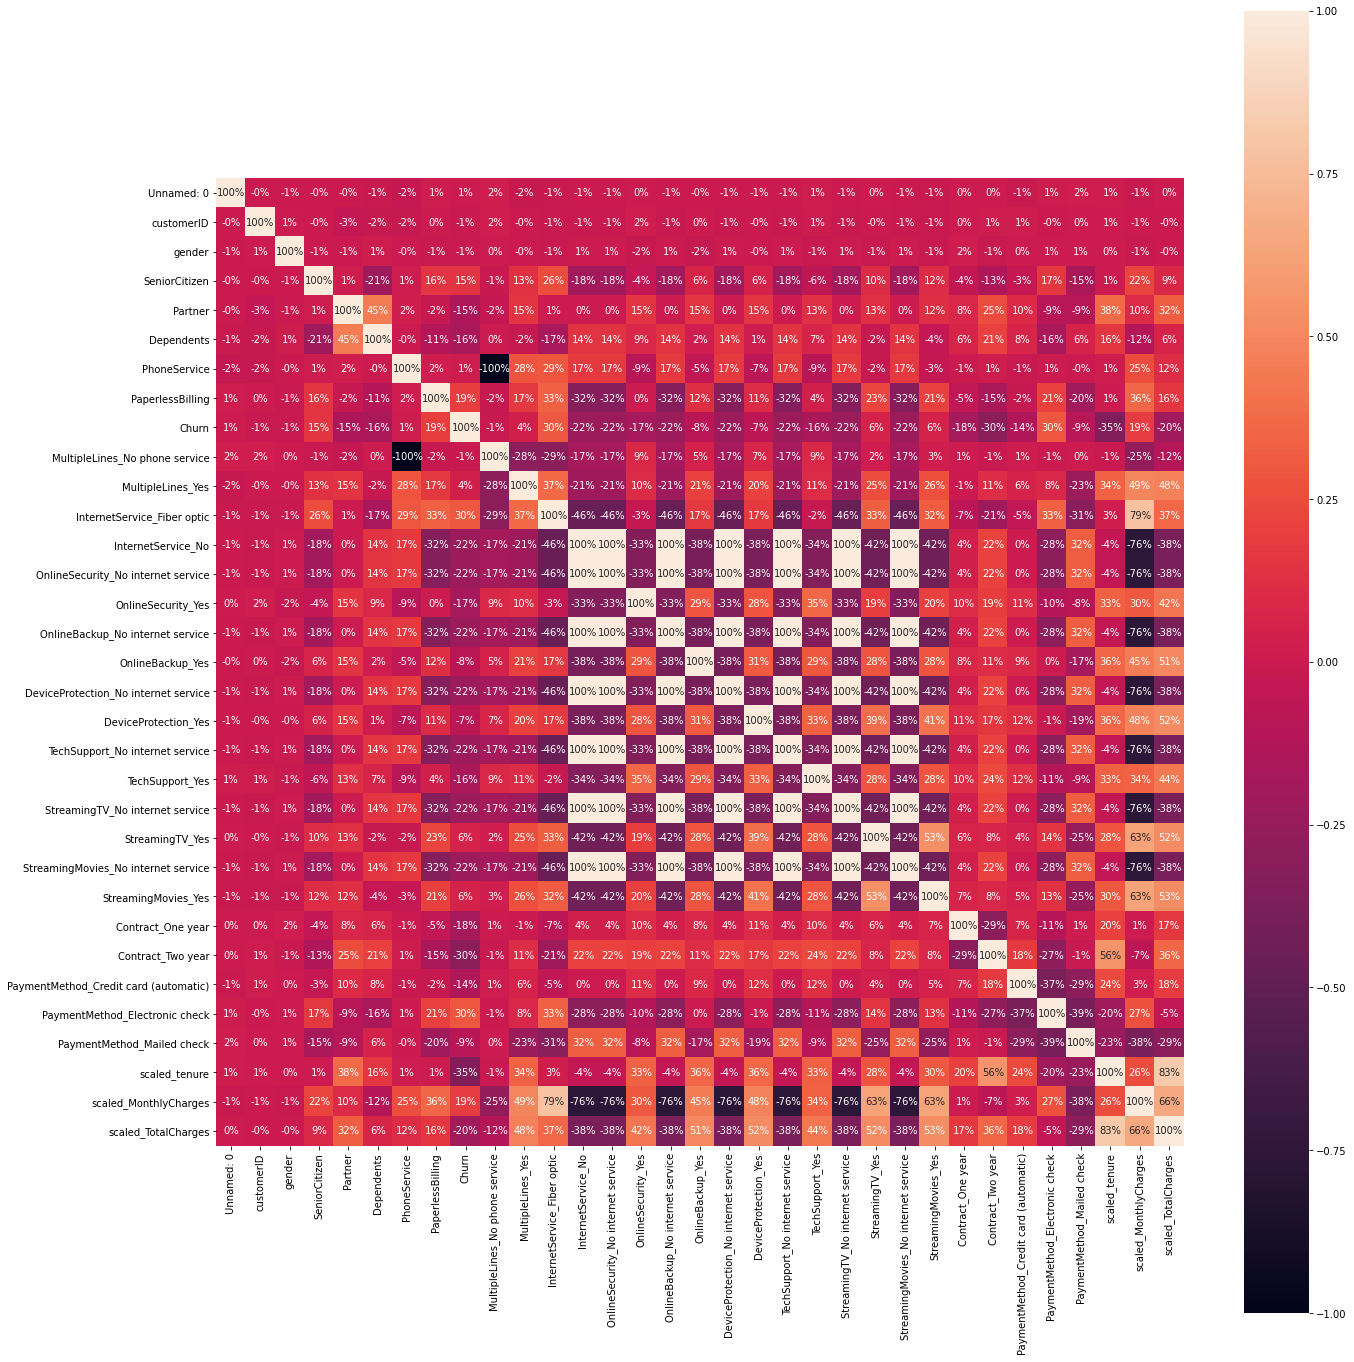

In [ ]:
# criando matriz de correlação
corr = df_prep.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, fmt='.0%', annot=True, square=True)
plt.tight_layout()

### Seleção de variáveis

Nem todas as variáveis do dataset são interessantes e/ou relevantes para construirmos o modelo de Machine Learning.

Iremos desconsiderar as variáveis `Unnamed: 0` e `customerID` pois não nos trazem nenhuma informação relevante.

Além disso, vamos desconsiderar também as variáveis `MultipleLines_Yes`, `MultipleLines_No phone service`, `PhoneService` e `gender` por serem as variáveis que correlacionam pouco com a variável alvo.

Fazendo isto, diminuimos as chances de *overfitting* dos modelos e buscamos aumentar seus desempenhos. 

In [ ]:
# removendo as colunas desnecessarias
df_prep.drop(["Unnamed: 0", "customerID", "MultipleLines_Yes", "MultipleLines_No phone service", "PhoneService", "gender"], axis=1, inplace=True)
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          5986 non-null   int64  
 1   Partner                                5986 non-null   int64  
 2   Dependents                             5986 non-null   int64  
 3   PaperlessBilling                       5986 non-null   int64  
 4   Churn                                  5986 non-null   int64  
 5   InternetService_Fiber optic            5986 non-null   uint8  
 6   InternetService_No                     5986 non-null   uint8  
 7   OnlineSecurity_No internet service     5986 non-null   uint8  
 8   OnlineSecurity_Yes                     5986 non-null   uint8  
 9   OnlineBackup_No internet service       5986 non-null   uint8  
 10  OnlineBackup_Yes                       5986 non-null   uint8  
 11  Devi

Nosso dataset está pronto para passar para próxima etapa: construção do modelo de Machine Learning!

## Modelo de Machine Learning

Neste primeiro momento da fase de desenvolvimento do modelo de Machine Learning, optamos por não balancear o dataset.

Iremos treinar o modelo **sem balancear** o dataset e observar seu desempenho.

A **métrica a ser avaliada será `recall`** pois o que nos interessa mais são as previsões positivas corretas, no caso, quantos *churns* foram identificados corretamente.




### Divisão do dataset

Vamos dividir nosso dataset entre treino e teste.


In [ ]:
# separar em feature matrix e target vector
X = df_prep.drop("Churn", axis=1)
y = df_prep.Churn

# dividindo os dados entre treino, validação e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

### Baseline para estimar desempenho

Vamos criar um **baseline** com o Random Forest sem nenhuma alteração nos parâmetros, utilizando apenas os dados de treino.

Faremos a **validação cruzada** (cross-validation) utilizando a técnica K-fold para estimar o erro.



In [ ]:
# instanciando o modelo
model = RandomForestClassifier()

# cross-validation
score_baseline = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
print("Recall (baseline): %0.2f (+/-%0.2f)" %(score_baseline.mean(), score_baseline.std()*2))

Recall (baseline): 0.47 (+/-0.05)


Já temos um **parâmetro de 0.47 de recall** do baseline feito com os dados **desbalanceados**. Vamos agora balancear o dataset para treinar diversos modelos.

### Balanceamento dos dados

Faremos esse balanceamento com o **SMOTE** (*Synthetic Minority Oversampling Technique*) e vamos plotar novo gráfico de barras para visualizar o novo balanceamento.


1    3299
0    3299
dtype: int64


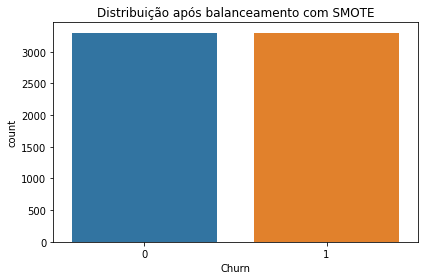

In [ ]:
# balanceando os dados com SMOTE
over = SMOTE()
X_train_s, y_train_s = over.fit_sample(X_train, y_train)

# ver novo balanceamento
print(pd.Series(y_train_s).value_counts())

# imprimir countplot
fig, ax = plt.subplots()
sns.countplot(y_train_s)
ax.set_title('Distribuição após balanceamento com SMOTE')
ax.set_xlabel('Churn')
plt.tight_layout()

In [ ]:
scores_s = cross_val_score(model, X_train_s, y_train_s, cv=5, scoring='recall')
print("Recall (após balanceamento): %0.2f (+/-%0.2f)" %(scores_s.mean(), scores_s.std()*2))

Recall (após balanceamento): 0.86 (+/-0.25)


Conforme previsto, o balanceamento dos dados com o **SMOTE aumentou para 0.86 de `recall`**, desempenho significativamente melhor que antes do balanceamento.

### Escolha do modelo

Vamos fazer a validação cruzada para vários modelos de classificação afim de obter seus desempenhos (através da métrica `recall`) e então escolher o mais adequado.

Os modelos são:

* Random Forest
* Decision Tree
* SGD
* SVC
* Regressão Logistica
* XGBoost
* LGBM

In [ ]:
# instanciando os modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

# cross-validation para avaliar o recall
model = []
recall = []


for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
  model.append(clf.__class__.__name__)
  scores = cross_val_score(clf, X_train_s, y_train_s, cv=5, scoring='recall')
  recall.append(scores.mean())

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.859080
DecisionTreeClassifier,0.782085
SGDClassifier,0.825134
SVC,0.820563
LogisticRegression,0.806917
XGBClassifier,0.855746
LGBMClassifier,0.844842


Obtivemos bons desempenhos para os modelos com os dados de treino. Vamos treinar e testar 3 modelos afim de ter como compará-los.

Vamos adotar os 3 modelos:

* Modelo 1 - Random Forest
* Modelo 2 - Logistic Regression
* Modelo 3 - XGBoost

Vale lembrar que a métrica levada em consideração aqui é `recall`, premissa deste projeto explicada anteriormente.

Agora vamos treinar os modelos finais e finalmente verificar seus desempenhos com os dados de teste que até então estavam reservados e ainda não foram usados.

### Modelo 1 - Random Forest



Relatório de classificação:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1100
           1       0.60      0.57      0.59       397

    accuracy                           0.78      1497
   macro avg       0.72      0.72      0.72      1497
weighted avg       0.78      0.78      0.78      1497

AUC: 0.7168



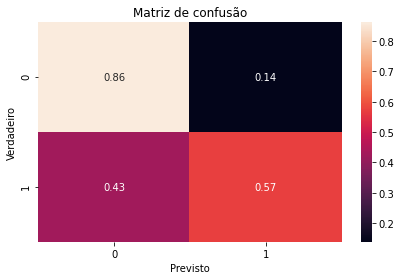

In [ ]:
# instanciando o modelo 1
model_1 = RandomForestClassifier()

# treinando o modelo 1
model_1.fit (X_train_s, y_train_s)

# fazendo previsões com dados de teste
y_pred_1 = model_1.predict(X_test)

# imprimindo relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test, y_pred_1))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_1)))

# plotando a matriz de confusão
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_1, normalize='true'), annot=True, ax=ax)
ax.set_title("Matriz de confusão")
ax.set_ylabel("Verdadeiro")
ax.set_xlabel("Previsto")
plt.tight_layout()

O modelo Random Forest **não** apresentou bom desempenho com os dados de teste. A taxa `recall` de 0.86 (treino) foi para 0.57 (teste), o que indica que o modelo não generalizou bem para os novos dados.



### Modelo 2 - Logistic Regression

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1100
           1       0.52      0.79      0.63       397

    accuracy                           0.75      1497
   macro avg       0.71      0.76      0.72      1497
weighted avg       0.80      0.75      0.76      1497

AUC: 0.7646



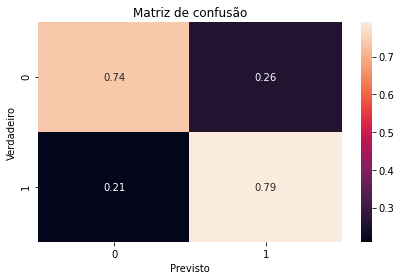

In [ ]:
# instanciando o modelo
model_2 = LogisticRegression()

# treinando o modelo 2
model_2.fit (X_train_s, y_train_s)

# fazendo previsões com dados de teste
y_pred_2 = model_2.predict(X_test)

# imprimindo relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test, y_pred_2))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_2)))

# plotando a matriz de confusão
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_2, normalize='true'), annot=True, ax=ax)
ax.set_title("Matriz de confusão")
ax.set_ylabel("Verdadeiro")
ax.set_xlabel("Previsto")
plt.tight_layout()

O modelo de regressão logística apresentou desempenho similar com os dados de treino e teste. A taxa `recall` de 0.81 (treino) foi para 0.79 (teste), podemos afirmar que esse desempenho é **satisfatório**.

### Modelo 3 - XGBoost

**Hiperparâmetros**

Vamos agora testar e otimizar os parâmetros do **XGBoost**, afim de obtermos uma performance ainda melhor.

**1- n_estimators**

O primeiro hiperparâmetro que vamos ajustar é o `n_estimators`.

Para isto, vamos fazer um grid search com `learning_rate=0.1`.





In [ ]:
# 1. ajuste do n_estimators
model = XGBClassifier(learning_rate=0.1)
param_grid={'n_estimators': range(0,500,50)}
    
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_s, y_train_s)

# imprimir resultados
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


Melhor: 0.872693 usando {'n_estimators': 50}


**2- max_depth**

Agora vamos ajustar o hiperparâmetro `max_depth`.

Para isto, vamos fazer um grid search com `learning_rate=0.1` e `n_estimators=50`.

In [ ]:
# 2. ajuste do max_depth
model = XGBClassifier(learning_rate=0.1,
                      n_estimators=50)

param_grid={'max_depth': range(1,11,2)}
    
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_s, y_train_s)

# imprimir resultados
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


Melhor: 0.873297 usando {'max_depth': 9}


**3- min_child_weight**

Agora vamos ajustar o hiperparâmetro `min_child_weight`.

Para isto, vamos fazer um grid search com `learning_rate=0.1`, `n_estimators=50` e `max_depth=9`.

In [ ]:
# 3. ajuste do min_child_weight
model = XGBClassifier(learning_rate=0.1,
                      n_estimators=50,
                      max_depth=9)

param_grid={'min_child_weight': range(1,8,1)}
    
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_s, y_train_s)

# imprimir resultados
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


Melhor: 0.874207 usando {'min_child_weight': 2}


**4- gamma**

Agora vamos ajustar o hiperparâmetro `gamma`.

Para isto, vamos fazer um grid search com `learning_rate=0.1`, `n_estimators=50`, `max_depth=9` e `min_child_weight=2`.



In [ ]:
# 4. ajuste do gamma
model = XGBClassifier(learning_rate=0.1,
                      n_estimators=50,
                      max_depth=9,
                      min_child_weight=2)

param_grid={'gamma':[i/10.0 for i in range(0,5)]}
    
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_s, y_train_s)

# imprimir resultados
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


Melhor: 0.876027 usando {'gamma': 0.2}


**5- subsample e colsample_bytree**

Agora vamos ajustar os hiperparâmetros `subsample` e `colsample_bytree`.

Para isto, vamos fazer um grid search com `learning_rate=0.1`, `n_estimators=50`, `max_depth=9`, `min_child_weight=2` e `gamma=0.2`.

In [ ]:
# 5. ajuste do subsample e colsample_bytree
model = XGBClassifier(learning_rate=0.1,
                      n_estimators=50,
                      max_depth=9,
                      min_child_weight=2,
                      gamma=0.2)

param_grid={'subsample':[i/10.0 for i in range(6,10)],
            'colsample_bytree':[i/10.0 for i in range(6,10)]}
    
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_s, y_train_s)

# imprimir resultados
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


Melhor: 0.876938 usando {'colsample_bytree': 0.9, 'subsample': 0.9}


**6- lambda e alpha**

Agora vamos ajustar os hiperparâmetros de **regularização** `lambda` e `alpha`.

Para isto, vamos fazer um grid search com `learning_rate=0.1`, `n_estimators=50`, `max_depth=9`, `min_child_weight=2`, `gamma=0.2`, `colsample_bytree=0.9` e `subsample=0.9`.

In [ ]:
# 6. ajuste do lambda e alpha
model = XGBClassifier(learning_rate=0.1,
                      n_estimators=50,
                      max_depth=9,
                      min_child_weight=2,
                      gamma=0.2,
                      colsample_bytree=0.9,
                      subsample=0.9)

param_grid={'reg_lambda':[i/100.0 for i in range(0,10)],
            'reg_alpha':[i/100.0 for i in range(0,10)]}
    
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_s, y_train_s)

# imprimir resultados
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


Melhor: 0.876939 usando {'reg_alpha': 0.07, 'reg_lambda': 0.05}


**7- learning rate**

Agora que já ajustamos vários hiperparâmetros, vamos ajustar a `learning_rate` que foi fixada no início.

Para isto, vamos fazer um grid search com todos os hiperparâmetros ajustados anteriormente.

In [ ]:
# 7. ajuste da learning_rate
model = XGBClassifier(n_estimators=50,
                      max_depth=9,
                      min_child_weight=2,
                      gamma=0.2,
                      colsample_bytree=0.9,
                      subsample=0.9,
                      reg_lambda=0.07,
                      reg_alpha=0.05)

param_grid={'learning_rate':[i/100.0 for i in range(0,10)]}
    
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_s, y_train_s)

# imprimir resultados
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


Melhor: 0.876332 usando {'learning_rate': 0.07}


Com vários hiperparâmetros ajustados (vale ressaltar que o XGBoost possui mais dos que abordamos aqui), chegamos em uma `recall` de 0.876, levemente mais alta que a inicial de 0.855. Vamos então treinar o modelo 3 final.



Relatório de classificação:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1100
           1       0.56      0.62      0.59       397

    accuracy                           0.77      1497
   macro avg       0.71      0.73      0.72      1497
weighted avg       0.78      0.77      0.78      1497

AUC: 0.7251



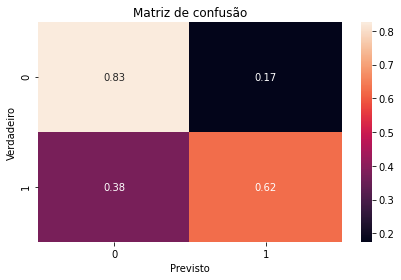

In [ ]:
# instanciando o modelo 3
model_3 = XGBClassifier(learning_rate=0.07,
                      n_estimators=50,
                      max_depth=9,
                      min_child_weight=2,
                      gamma=0.2,
                      colsample_bytree=0.9,
                      subsample=0.9,
                      reg_lambda=0.07,
                      reg_alpha=0.05)

# treinando o modelo 3
model_3.fit(X_train_s, y_train_s)


# fazendo previsões com dados de teste
y_pred_3 = model_3.predict(X_test.values)

# imprimindo relatório de classificação
print("Relatório de classificação:")
print(classification_report(y_test, y_pred_3))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_3)))

# plotando a matriz de confusão
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_3, normalize='true'), annot=True, ax=ax)
ax.set_title("Matriz de confusão")
ax.set_ylabel("Verdadeiro")
ax.set_xlabel("Previsto")
plt.tight_layout()


O modelo XGBoost, apesar de todo o processo de *hyperparameter tunning* 
**não** apresentou bom desempenho com os dados de teste. A taxa `recall` de 0.855 (treino) foi para 0.62 (teste), o que indica que o modelo não generalizou bem para os novos dados.


## Conclusão

Após concluir todas as etapas de um projeto de Machine Learning é possível perceber que dentre os modelos treinados, o modelo de **regressão logística** foi o modelo que apresentou **desempenho mais satisfatório**, considerando a métrica `recall` adotada como premissa para este projeto.

Os modelos Random Forest e XGBoost apresentaram bom desempenho com os dados de treino, porém não generalizaram, ou seja, não mantiveram seus desempenhos com os dados de teste.

É possível experimentar outros métodos de padronização e balanceamento dos dados afim de melhorar os desempenhos. O modelo XGBoost especialmente tem muito potencial para obter desempenho acima até do modelo de regressão logística, devido a grande quantidade de hiperparâmetros que podem ser ajustados.